Imports

In [16]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statistics
import math
import numbers

from tqdm import tqdm
from time import sleep
import xlsxwriter
import openpyxl
import os
import glob

Data Scraping

In [32]:
# Scrape the data for the list of companies in the S&P 500 from tables off the wikipedia page
## List of DataFrame
wikipedia_tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')

# Take the first table, which has the current list of companies
## DataFrame
snp500_table = wikipedia_tables[0]

# View the column attributes
## List of String
snp500_table_columns = snp500_table.columns.values.tolist()

# Take the ticker symbols
## Series
snp500_tickers = snp500_table.loc[:,'Symbol']

# Reformat
## List of String
snp500_tickers = list(snp500_tickers)

Fundamental Data

In [3]:
# This method is extremely slow because fundamental data has to be retrieved from Ticker objects in yfinance
# Ticker objects download data slowly because they don't have a batch call feature
# So instead, we will run this cell once and write the results to a spreadsheet to then be read in again as our fundamental data

"""
# Create a place of storage for fundamental stock information (P/E, market cap, location)
## Dict of (String,DataFrame)
fundamentals = {}

stocks = yf.Tickers(snp500_tickers)

# Loop through the ticker symbols
for ticker_string in tqdm(snp500_tickers):
    stock = stocks.tickers ## Dict of (String,Ticker)
    df = pd.DataFrame.from_dict(stock[ticker_string].info, orient="index") ## DataFrame
    df.columns = ['Value']
    fundamentals[ticker_string] = df
"""

'\n# Create a place of storage for fundamental stock information (P/E, market cap, location)\n## Dict of (String,DataFrame)\nfundamentals = {}\n\nstocks = yf.Tickers(snp500_tickers)\n\n# Loop through the ticker symbols\nfor ticker_string in tqdm(snp500_tickers):\n    stock = stocks.tickers ## Dict of (String,Ticker)\n    df = pd.DataFrame.from_dict(stock[ticker_string].info, orient="index") ## DataFrame\n    df.columns = [\'Value\']\n    fundamentals[ticker_string] = df\n'

Writing to Excel

In [4]:
"""
writer = pd.ExcelWriter('Fundamentals.xlsx', engine='xlsxwriter')

for df_name, df in fundamentals.items():
    df.to_excel(writer, sheet_name=df_name)

writer.save()
"""

"\nwriter = pd.ExcelWriter('Fundamentals.xlsx', engine='xlsxwriter')\n\nfor df_name, df in fundamentals.items():\n    df.to_excel(writer, sheet_name=df_name)\n\nwriter.save()\n"

Converting from Excel to CSV

In [5]:
# Use a VBA script to convert each sheet to a seperate CSV

Reading from CSV

In [37]:
# Remove BF.B and BRK.B to be added afterwards
snp500_tickers_503 = snp500_tickers.copy()
snp500_tickers_503.remove('BRK.B')
snp500_tickers_503.remove('BF.B')
snp500_tickers_503.sort()

# Sort the tickers alphabetically so they match with the list of csv files
snp500_tickers.sort()

In [38]:
fundamentals = {}

# Get to the working directory and enter the folder with the sheets
path = os.getcwd()+"/Fundamentals Sheets"
# Take all the csv files
files = glob.glob(os.path.join(path, "*.csv"))

# Loop through all the csv files to make a dataframe from each sheet
for i in tqdm(range(len(files))):
    file = files[i]
    ticker_string = snp500_tickers_503[i]
    # Encode as latin-1 to account for special characters
    df = pd.read_csv(file, encoding='latin-1',index_col=0)
    df.columns = ['Value']
    fundamentals[ticker_string] = df

100%|███████████████████████████████████████| 503/503 [00:01<00:00, 260.62it/s]


In [39]:
# Example ticker
example = 'MMM'

# View all the fundamental data's attributes
## List of String
fundamental_attributes = fundamentals[example].index.values.tolist()

Outstanding Shares

Here we are making a simplification to the model. Even though the number of shares change over time because of things like stock splits, we will use the current number of shares to determine the historical market capitalization of each company and the index. Also, we will not be doing a float adjustment as is done for the real S&P500.

In [54]:
## Dict
outstanding_shares = dict()

## Loop through the ticker symbols to add each outstanding shares to the dict
for ticker_string in snp500_tickers_503:
     outstanding_shares[ticker_string] = float(fundamentals[ticker_string].loc['sharesOutstanding','Value'])
        
# Find all the companies without outstanding shares data, including 
companies_without_shares = []
for key, value in outstanding_shares.items():
    if math.isnan(value):#or not isinstance(value, numbers.Number): 
        companies_without_shares.append(key)

# Turns out to be NVDA (plus BRK.B and BF.B which don't have price data)
print(companies_without_shares)

['OGN']


Fix to Add Missing Outstanding Shares Values

In [55]:
yf.Ticker(

# yfinance does not have the outstandingShares attribute for the following three companies
# so we will look online for the number of shares in 2021 
# so we will not add them

#berk_shares = 2.281 * math.pow(10,9)
#bf_shares = 0.481 * math.pow(10,9)
ogn_shares = 2.532 * math.pow(10,6)

#berk = yf.Ticker('BRK.B')
#fundamentals['BRK.B'] = berk.info['sharesOutstanding']
#outstanding_shares['BRK.B'] = berk_shares

#bf = yf.Ticker('BF.B')
#fundamentals['BF.B']= bf.info['sharesOutstanding']
#outstanding_shares['BF.B'] = bf_shares

#ogn = yf.Ticker('OGN')
#fundamentals['OGN']= ogn.info['sharesOutstanding']
outstanding_shares['OGN'] = ogn_shares

Historical Data

In [183]:
# Retrieve stock data through a batch call for a faster download
## MultiIndex
snp500_data = yf.download(
    tickers = snp500_tickers,
    period = '1y',
    interval = '1d',
    group_by='column'
)

[*********************100%***********************]  505 of 505 completed

2 Failed downloads:
- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


Removing Dates and Companies With Missing Values

In [184]:
# If desired, convert multi-level data to single-level data, but we won't do that now
## MultiIndex -> DataFrame
snp500_data_singlelvl = snp500_data.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)

# High Low Open Close AdjClose Volume

# We want adjusted close because it accounts for dividends and stock splits
# We don't want dividends and stock splits to confound anything when analyzing correlation, etc.
## DataFrame
prices = snp500_data['Adj Close']

# Remove missing values
# This accounts for both holidays and weekends (normal)
prices = prices.dropna(axis=0, how='all')


# Fill in missing values with last observation,
# This accounts for yfinance's missing data
prices = prices.fillna(axis=0, method='ffill')
# And fill in the first value is missing
prices = prices.fillna(axis=0, method='bfill')

# Check for the tickers with no price information
# And remove them from the dataframe as well as the index
no_price_info = prices.columns[prices.isna().any()].tolist()
prices = prices.dropna(axis=1, how='any')

# The dates to loop through
## Series
dates = prices.index

Calculating Capitalization Weighted Index Weights

This tells the percentage that companies in the index affect it. For instance, AAPL is around 6% of the S&P500.

In [190]:
# The total market capitalization of the S&P500 has changed throughout time, so we need one market cap for each time step
# We will store the market caps here
snp_market_caps = []
all_cap_weights = pd.DataFrame(columns=snp500_tickers_503, index=dates)
# Loop through both dates and companies to calculate market caps and weights for each time step

for date in dates:
    
    snp_market_cap_at_time_t = 0
    market_caps_at_time_t = []
    
    for ticker_string in snp500_tickers_503:
        # Market Cap = Stock Price * Outstanding Shares
        price = prices.loc[date,ticker_string]
        shares = outstanding_shares[ticker_string]
        
        #print(ticker_string)
        #print(shares)
        market_cap = price*shares
        #print(market_cap)
        # Add to the list of company market caps
        market_caps_at_time_t.append(market_cap)
        snp_market_cap_at_time_t += market_cap
    
    snp_market_caps.append(snp_market_cap_at_time_t)
    market_caps_array = np.array(market_caps_at_time_t)
    weights_at_time_t = market_caps_array/snp_market_cap_at_time_t
    all_cap_weights.loc[date] = pd.Series(weights_at_time_t, index=snp500_tickers_503)

                   A       AAL       AAP      AAPL      ABBV       ABC  \
Date                                                                     
2020-09-18  0.001048  0.000299  0.000335  0.061508  0.005318  0.000694   
2020-09-21  0.001047   0.00028  0.000327  0.064141  0.005322  0.000695   
2020-09-22  0.001042  0.000281  0.000328  0.064525  0.005242  0.000685   
2020-09-23  0.001051  0.000278  0.000328    0.0634  0.005287  0.000694   
2020-09-24  0.001041  0.000274  0.000328  0.063856  0.005197  0.000696   
...              ...       ...       ...       ...       ...       ...   
2021-09-13  0.001319  0.000317  0.000316  0.062613  0.004811  0.000651   
2021-09-14   0.00133  0.000317  0.000321  0.062411  0.004796  0.000652   
2021-09-15  0.001329  0.000317  0.000327  0.062252  0.004813  0.000661   
2021-09-16  0.001328  0.000326  0.000331  0.062246  0.004834  0.000653   
2021-09-17  0.001345  0.000326  0.000331  0.061661  0.004862  0.000655   

                ABMD       ABT       

Capitalization Weighted S&P 500

In [191]:
# Set up our index, which will be an array of the S&P500 at different time points
cap_snp500_data = []

for date in dates:
    cap_snp500_at_time_t = 0
    for ticker_string in snp500_tickers_503:
        # Amount of Stock = Stock Price * Cap Weight
        price = prices.loc[date,ticker_string]
        weight = all_cap_weights.loc[date,ticker_string]
        shares = outstanding_shares[ticker_string]
        # Just makes the index a more understandable number
        divisor = 10000000000
        # SNP500 is the sum of all the weighted stocks
        cap_snp500_at_time_t += price*shares/divisor
    # Add for each date
    cap_snp500_data.append(cap_snp500_at_time_t)

cap_snp500 = pd.DataFrame(cap_snp500_data, columns=['Price'], index=dates)
print(cap_snp500)

                  Price
Date                   
2020-09-18  2852.954508
2020-09-21  2818.795878
2020-09-22  2846.083932
2020-09-23  2775.094625
2020-09-24  2783.548960
...                 ...
2021-09-13  3948.237426
2021-09-14  3923.114596
2021-09-15  3957.304658
2021-09-16  3951.298493
2021-09-17  3915.618743

[252 rows x 1 columns]


Equal Weighted S&P 500

In [192]:
all_equal_weights = pd.DataFrame(columns=snp500_tickers_503, index=dates)

all_equal_weights = all_equal_weights.fillna(1/503.0)

# Set up our index, which will be an array of the S&P500 at different time points
equal_snp500_data = []

for date in dates:
    equal_snp500_at_time_t = 0
    for ticker_string in snp500_tickers_503:
        # Amount of Stock = Stock Price * Equal Weight
        price = prices.loc[date,ticker_string]
        weight = all_equal_weights.loc[date,ticker_string]
        shares = outstanding_shares[ticker_string]
        # Just makes the index a more understandable number
        divisor = 1/20.0
        # SNP500 is the sum of all the weighted stocks
        equal_snp500_at_time_t += price*weight/divisor
    # Add for each date
    equal_snp500_data.append(equal_snp500_at_time_t)

equal_snp500 = pd.DataFrame(equal_snp500_data, columns=['Price'], index=dates)
print(equal_snp500)

                  Price
Date                   
2020-09-18  2913.383654
2020-09-21  2865.237032
2020-09-22  2899.234693
2020-09-23  2831.756796
2020-09-24  2838.009242
...                 ...
2021-09-13  4101.148324
2021-09-14  4083.623160
2021-09-15  4115.123330
2021-09-16  4114.979122
2021-09-17  4084.091465

[252 rows x 1 columns]


Graphing the S&P500 Indices

The exact values are not the same as the real S&P indices because:

(1) they don't use the same divisor as the real S&P500 (least important)

(2) they don't adjust the outstanding shares to free float shares

(3) they don't include BRK.B (Berkshire Hathaway B) and BF.B (Brown-Forman B) (most important)

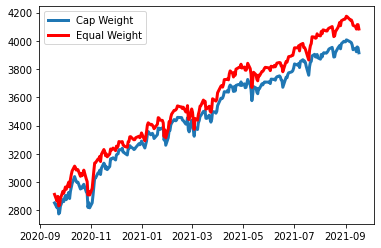

In [193]:
plt.plot(cap_snp500.index, cap_snp500['Price'], label='Cap Weight', linewidth=3)
plt.plot(equal_snp500.index, equal_snp500['Price'], color='red', label='Equal Weight', linewidth=3)

plt.legend()

plt.show()

Statistical Measures

Correlation

In [194]:
x = cap_snp500['Price'].to_numpy()
y = equal_snp500['Price'].to_numpy()
print(np.corrcoef(x,y))

cap_returns = cap_snp500.pct_change()
equal_returns = equal_snp500.pct_change()

Average Daily Returns

In [197]:
print('Cap Weighted')
print(np.mean(cap_returns)['Price'])
print('Equal Weighted')
print(np.mean(equal_returns)['Price'])

Cap Weighted
0.001300777926942965
Equal Weighted
0.0013861749093047066


Volatility

In [198]:
print('Cap Weighted')
print(np.std(cap_returns)['Price'])
print('Equal Weighted')
print(np.std(equal_returns)['Price'])

Cap Weighted
0.008775310777531591
Equal Weighted
0.008883406042741517
